In [65]:
import pandas as pd     
import numpy as np
from collections import Counter
from pprint import pprint

# Example from lecture:

[slides](https://www.cs.cmu.edu/~hchai2/courses/10701/lectures/Lecture2.pdf)

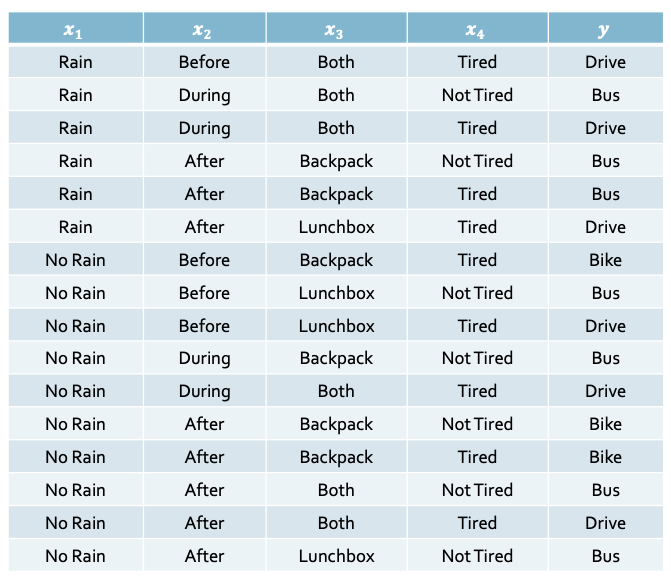

In [66]:
data = {
    "x1": [
        "Rain", "Rain", "Rain", "Rain", "Rain", "Rain",
        "No Rain", "No Rain", "No Rain", "No Rain", "No Rain",
        "No Rain", "No Rain", "No Rain", "No Rain", "No Rain"
    ],
    "x2": [
        "Before", "During", "During", "After", "After", "After",
        "Before", "Before", "Before", "During", "During",
        "After", "After", "After", "After", "After"
    ],
    "x3": [
        "Both", "Both", "Both", "Backpack", "Backpack", "Lunchbox",
        "Backpack", "Lunchbox", "Lunchbox", "Backpack", "Both",
        "Backpack", "Backpack", "Both", "Both", "Lunchbox"
    ],
    "x4": [
        "Tired", "Not Tired", "Tired", "Not Tired", "Tired", "Tired",
        "Tired", "Not Tired", "Tired", "Not Tired", "Tired",
        "Not Tired", "Tired", "Not Tired", "Tired", "Not Tired"
    ],
    "y": [
        "Drive", "Bus", "Drive", "Bus", "Bus", "Drive",
        "Bike", "Bus", "Drive", "Bus", "Drive",
        "Bike", "Bike", "Bus", "Drive", "Bus"
    ]
}

df = pd.DataFrame(data)

In [67]:
df

,x1,x2,x3,x4,y
0,Rain,Before,Both,Tired,Drive
1,Rain,During,Both,Not Tired,Bus
2,Rain,During,Both,Tired,Drive
3,Rain,After,Backpack,Not Tired,Bus
4,Rain,After,Backpack,Tired,Bus
5,Rain,After,Lunchbox,Tired,Drive
6,No Rain,Before,Backpack,Tired,Bike
7,No Rain,Before,Lunchbox,Not Tired,Bus
8,No Rain,Before,Lunchbox,Tired,Drive
9,No Rain,During,Backpack,Not Tired,Bus


In [69]:
features = ['x1', 'x2', 'x3', 'x4']
label = 'y'

X = df[features]
Y = df[label]

# Probability

In [97]:
def probability_(x, X):
    counts = Counter(X)
    total = len(X)
    prob = counts[x] / total
    return prob

In [98]:
probability_('Drive', Y)


0.375

In [72]:
def probability(x, X):
    return X.value_counts(normalize=True)[x]

In [73]:
probability('Drive', Y)


np.float64(0.375)

# Entropy

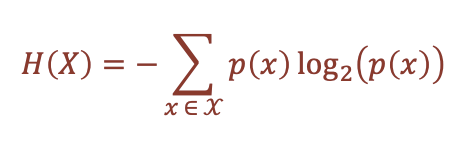

In [74]:
def entropy(X):
    return -sum(probability(x, X) * np.log2(probability(x, X)) for x in X.unique())

In [75]:
entropy(df['y'])

np.float64(1.5052408149441479)

# Mutual information

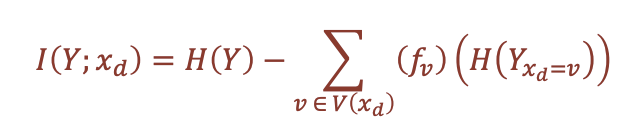

In [76]:
def mutual_information(feature, X, Y):
    vxd = X[feature].unique()
    return entropy(Y) - sum(probability(v, X[feature]) * entropy(Y[X[feature] == v]) for v in vxd)


In [77]:
(
mutual_information('x1', X, Y), 
mutual_information('x2', X, Y), 
mutual_information('x3', X, Y), 
mutual_information('x4', X, Y),
)

(np.float64(0.14839669340998007),
 np.float64(0.13024081494414785),
 np.float64(0.5358798771737143),
 np.float64(0.5576620987735124))

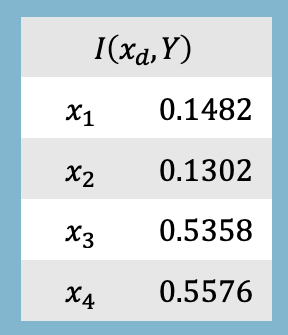

In [78]:
def best_feature(X, Y):
    return max(X.columns, key=lambda feature: mutual_information(feature, X, Y))

In [79]:
best_feature(X, Y)

'x4'

## Manually follow tree building logic

In [80]:
df[X['x4'] == 'Tired']

,x1,x2,x3,x4,y
0,Rain,Before,Both,Tired,Drive
2,Rain,During,Both,Tired,Drive
4,Rain,After,Backpack,Tired,Bus
5,Rain,After,Lunchbox,Tired,Drive
6,No Rain,Before,Backpack,Tired,Bike
8,No Rain,Before,Lunchbox,Tired,Drive
10,No Rain,During,Both,Tired,Drive
12,No Rain,After,Backpack,Tired,Bike
14,No Rain,After,Both,Tired,Drive


In [81]:
X_tired = X[X['x4'] == 'Tired']
Y_tired = Y[X['x4'] == 'Tired']

In [82]:
(
mutual_information('x1', X_tired[['x1', 'x2', 'x3']], Y_tired), 
mutual_information('x2', X_tired[['x1', 'x2', 'x3']], Y_tired), 
mutual_information('x3', X_tired[['x1', 'x2', 'x3']], Y_tired), 
)

(np.float64(0.3244093931715556),
 np.float64(0.2516291673878229),
 np.float64(0.9182958340544896))

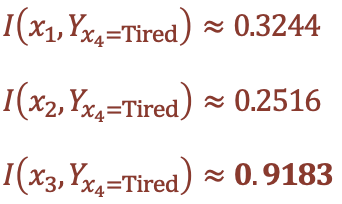

In [83]:
best_feature(X[X['x4'] == 'Tired'][['x1', 'x2', 'x3']], Y[X['x4'] == 'Tired'])

'x3'

In [84]:
(
mutual_information('x1', X_tired[X_tired['x3'] == 'Both'][['x1', 'x2']], Y_tired[X_tired['x3'] == 'Both']), 
mutual_information('x2', X_tired[X_tired['x3'] == 'Both'][['x1', 'x2']], Y_tired[X_tired['x3'] == 'Both']), 
)

(np.float64(-0.0), np.float64(-0.0))

In [85]:
Y_tired[X_tired['x3'] == 'Both']

0     Drive
2     Drive
10    Drive
14    Drive
Name: y, dtype: object

In [86]:
best_feature(X[X['x3'] == 'Both'][['x1', 'x2']], Y[X['x3'] == 'Both'])

'x2'

In [87]:
def build_tree(X, Y):
    if len(Y.unique()) == 1:
        return Y.iloc[0]
    
    splitter = best_feature(X, Y)
    tree = { splitter: {} }
    for val in X[splitter].unique():
        tree[splitter][val] = build_tree(X[X[splitter] == val][X.columns.drop(splitter)], Y[X[splitter] == val])
    return tree

tree = build_tree(X, Y)

pprint(tree)

{'x4': {'Not Tired': {'x3': {'Backpack': {'x1': {'No Rain': {'x2': {'After': 'Bike',
                                                                    'During': 'Bus'}},
                                                 'Rain': 'Bus'}},
                             'Both': 'Bus',
                             'Lunchbox': 'Bus'}},
        'Tired': {'x3': {'Backpack': {'x1': {'No Rain': 'Bike', 'Rain': 'Bus'}},
                         'Both': 'Drive',
                         'Lunchbox': 'Drive'}}}}


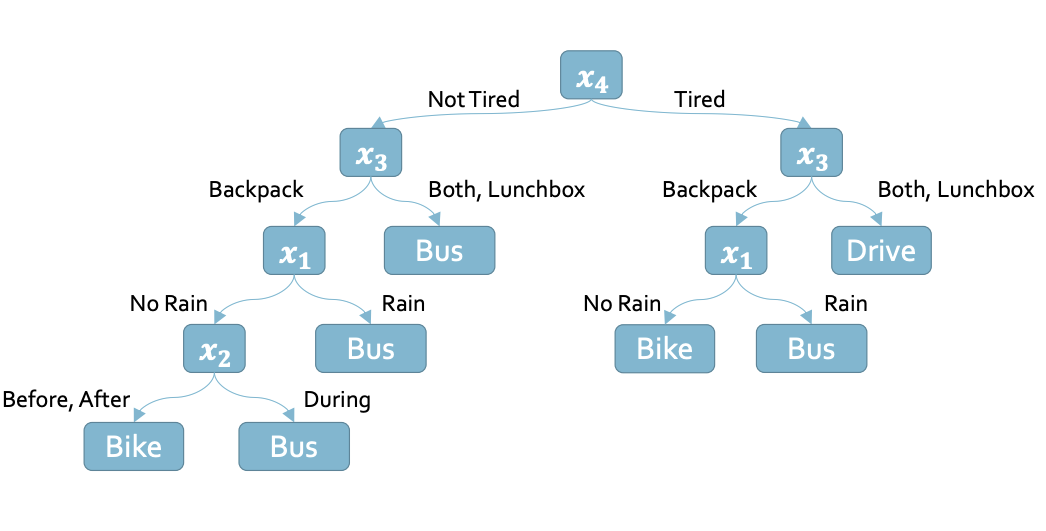

In [92]:
def predict(x, tree):
    if not tree or type(tree) is str:
        return tree
    root = list(tree.keys())[0]
    if x[root].iloc[0] not in tree[root]:
        return None
    return predict(x, tree[root][x[root].iloc[0]])



In [95]:
test_data = {
    "x1": "No Rain",
    "x2": "After",
    "x3": "Backpack",
    "x4": "Not Tired"
}
test_df = pd.DataFrame([test_data])


In [96]:
pprint(predict(test_df, tree))

'Bike'
